In [24]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

In [54]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

Gen RAM Free: 9.3 GB  | Proc size: 11.2 GB
GPU RAM Free: 11844MB | Used: 3235MB | Util  21% | Total 15079MB


In [0]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2 as cv
import imutils
import numpy as np
from matplotlib import pyplot as plt
import time
from os import listdir

%matplotlib inline

In [0]:
def crop_brain_contour(image, plot=False):
  gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
  #print(image.shape)
  #print(gray.shape)
  gray = cv.GaussianBlur(gray,(5,5),0)

  thresh = cv.threshold(gray,45,255,cv.THRESH_BINARY)[1]
  #print(thresh)
  thresh = cv.erode(thresh, None, iterations=2)
  thresh = cv.dilate(thresh,None,iterations=2)

  cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv.contourArea)

  extLeft = tuple(c[c[:,:,0].argmin()][0])
  extRight = tuple(c[c[:,:,0].argmax()][0]) 
  extTop = tuple(c[c[:,:,1].argmin()][0])
  extBot = tuple(c[c[:,:,1].argmax()][0])

  new_image = image[extTop[1]:extBot[1],extLeft[0]:extRight[0]]

  if plot:
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(image)

    plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Original image')
    plt.subplot(1,2,2)
    plt.imshow(new_image)

    plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Cropped Image')
    plt.show()

  return new_image

In [0]:
ex_img = cv.imread('/content/augment_data/yes/aug_Y100_0_4485.jpg')

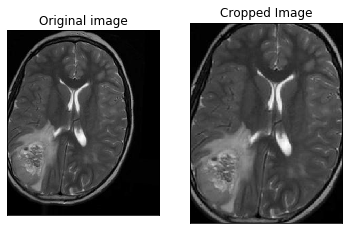

In [6]:
ex_new_img = crop_brain_contour(ex_img,True)

In [7]:
ex_img.shape

(348, 287, 3)

In [8]:
ex_new_img.shape

(296, 225, 3)

In [0]:
def load_data(dir_list,image_size):
  x=[]
  y=[]

  image_width,image_height = image_size
  for directory in dir_list:
    for filename in listdir(directory):
      #print(directory)
      #print(filename)
      image = cv.imread(directory + '/' + filename)
      #print(image)
      image = crop_brain_contour(image,plot=False)
      image = cv.resize(image,dsize=(image_width,image_height),interpolation = cv.INTER_CUBIC)

      image=image/255
      x.append(image)

      if directory[-3:] == 'yes':
        y.append([1])
      else:
        y.append([0]) 

  X = np.array(x)
  y = np.array(y)

  X,y = shuffle(X,y)

  print(f'Number of examples: {len(X)}')
  print(f'X shape:{X.shape}')
  print(f'Y shape:{y.shape}')

  return X,y

In [10]:
augmented_path = '/content/augment_data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples: 2063
X shape:(2063, 240, 240, 3)
Y shape:(2063, 1)


In [11]:
for label in [0,1]:
  print(label)

0
1


In [0]:
def plot_sample_images(X,y,n=50):
  for label in [0,1]:
    images = X[np.argwhere(y==label)]
    n_images = images[:n]

    columns = 10
    rows = int(n/columns)

    plt.figure(figsize=(20,10))

    i=1
    for image in n_images:
      plt.subplot(rows,columns,i)
      #print(image[0])
      plt.imshow(image[0])

      # remove ticks
      plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
      i+=1
    label_to_str = lambda label: "Yes" if label == 1 else "No"
    plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
    plt.show()

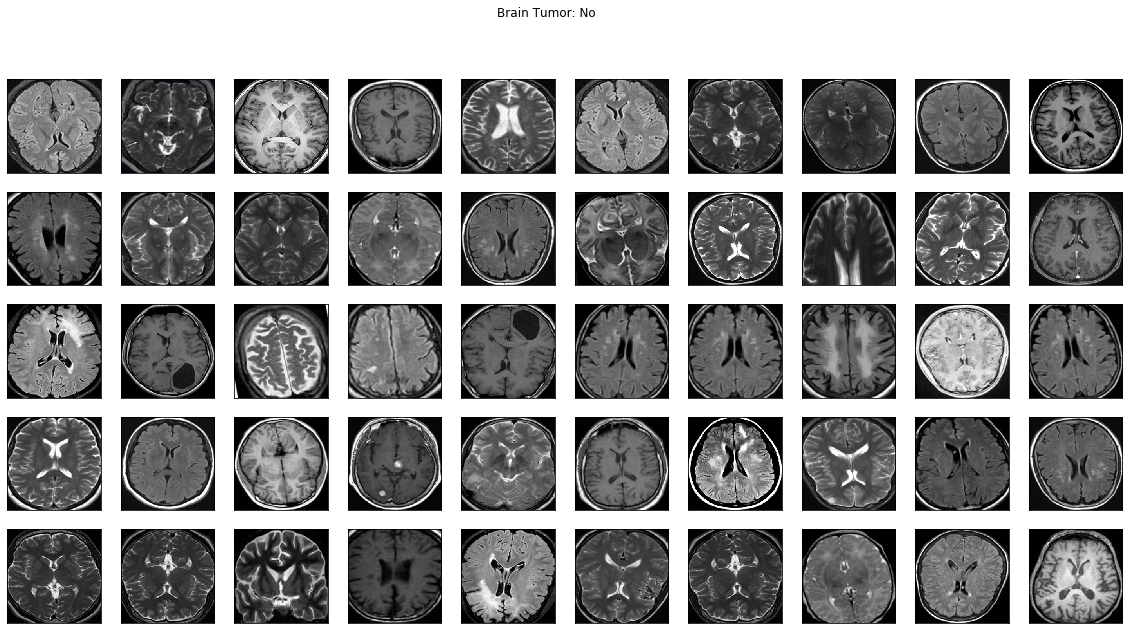

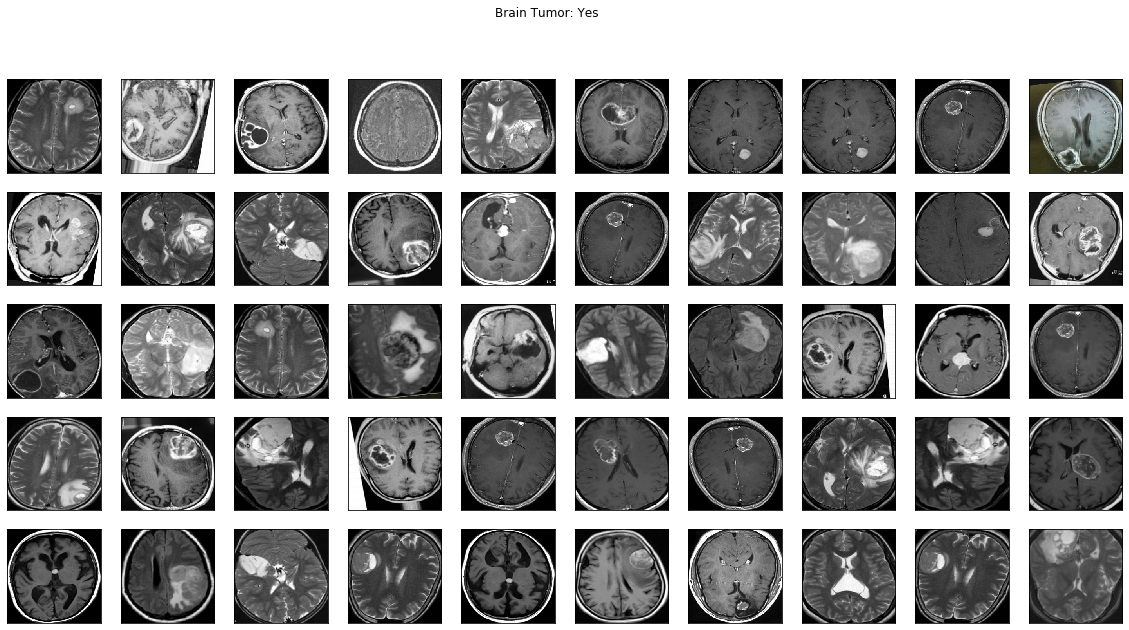

In [13]:
plot_sample_images(X,y,50)

In [0]:
def split_data(X, y, test_size=0.2):
  X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
  X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

  return X_train,y_train,X_val,y_val,X_test,y_test

In [0]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [16]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1444
number of development examples = 310
number of test examples = 309
X_train shape: (1444, 240, 240, 3)
Y_train shape: (1444, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (309, 240, 240, 3)
Y_test shape: (309, 1)


In [0]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [0]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [0]:
def build_model(image_shape):
  X_input = Input(image_shape)
  #print(X_input)
  X = ZeroPadding2D((2,2))(X_input)

  X = Conv2D(32, (7,7), strides=(1,1), name='conv0')(X)
  X = BatchNormalization(axis=3,name='bn0')(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((4,4),name='max_pool0')(X)

  X = MaxPooling2D((4,4),name='max_pool1')(X)

  X = Flatten()(X)

  X = Dense(1,activation='sigmoid',name='fc')(X)

  model = Model(inputs=X_input,outputs=X,name='TumorDetection')
  return model

In [39]:
IMG_SHAPE = IMG_WIDTH,IMG_HEIGHT,3
IMG_SHAPE

(240, 240, 3)

In [40]:
model = build_model(IMG_SHAPE)

Tensor("input_3:0", shape=(?, 240, 240, 3), dtype=float32)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [42]:
model.summary()

Model: "TumorDetection"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)     

In [0]:
log_file_name = f'Brain_tumor_detection_cnn{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [0]:
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
checkpoint = ModelCheckpoint("/content/models/{}.model".format(filepath,monitor='val_acc',verbose=1, save_best_only=True, mode='max'))

In [53]:
start_time = time.time()

model.fit(x=X_train,y=y_train,batch_size=32,epochs=20,validation_data=(X_val,y_val),callbacks=[tensorboard,checkpoint])

end_time = time.time()
execution_time = (end_time-start_time)
print(f'Execution time: {hms_string(execution_time)}')

Train on 1444 samples, validate on 310 samples
Epoch 1/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.4432 - acc: 0.7964 - val_loss: 0.5741 - val_acc: 0.7129
Epoch 2/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.3821 - acc: 0.8289 - val_loss: 0.4998 - val_acc: 0.8032
Epoch 3/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.4742 - acc: 0.7846 - val_loss: 0.4595 - val_acc: 0.8000
Epoch 4/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.3350 - acc: 0.8608 - val_loss: 0.5019 - val_acc: 0.7677
Epoch 5/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.3075 - acc: 0.8740 - val_loss: 0.4983 - val_acc: 0.7742
Epoch 6/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.3500 - acc: 0.8629 - val_loss: 0.3725 - val_acc: 0.8323
Epoch 7/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.2554 - acc: 0.8996 - val_loss: 0.6179 - val_acc: 0.7161
E

In [55]:
start_time = time.time()

model.fit(x=X_train,y=y_train,batch_size=32,epochs=2,validation_data=(X_val,y_val),callbacks=[tensorboard,checkpoint])

end_time = time.time()
execution_time = (end_time-start_time)
print(f'Execution time: {hms_string(execution_time)}')

Train on 1444 samples, validate on 310 samples
Epoch 1/2
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.0744 - acc: 0.9841 - val_loss: 1.1522 - val_acc: 0.6613
Epoch 2/2
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.0854 - acc: 0.9792 - val_loss: 0.4075 - val_acc: 0.8742
Execution time: 0:0:8.2


In [82]:
start_time = time.time()

model.fit(x=X_train,y=y_train,batch_size=32,epochs=20,validation_data=(X_val,y_val),callbacks=[tensorboard,checkpoint])

end_time = time.time()
execution_time = (end_time-start_time)
print(f'Execution time: {hms_string(execution_time)}')

Train on 1444 samples, validate on 310 samples
Epoch 1/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.0298 - acc: 0.9979 - val_loss: 0.3377 - val_acc: 0.8774
Epoch 2/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.0310 - acc: 0.9979 - val_loss: 0.3183 - val_acc: 0.8839
Epoch 3/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.0254 - acc: 0.9986 - val_loss: 0.3241 - val_acc: 0.8935
Epoch 4/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.0404 - acc: 0.9952 - val_loss: 0.4754 - val_acc: 0.8484
Epoch 5/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.0415 - acc: 0.9924 - val_loss: 0.3187 - val_acc: 0.8677
Epoch 6/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.0302 - acc: 0.9965 - val_loss: 0.3173 - val_acc: 0.8871
Epoch 7/20
1444/1444 [==============================] - 4s 3ms/sample - loss: 0.0219 - acc: 0.9986 - val_loss: 0.3243 - val_acc: 0.8806
E

In [0]:
history = model.history.history
#train_loss = history['loss']
#plt.plot(train_loss, label='Training Loss')

In [84]:
for key in history.keys():
  print(key)

loss
acc
val_loss
val_acc


In [0]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

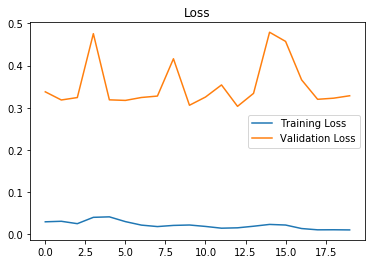

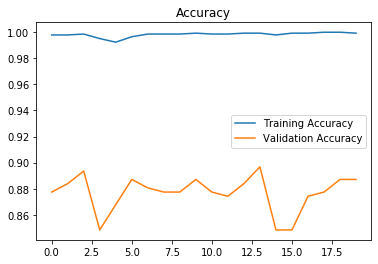

In [86]:
plot_metrics(history)

In [87]:
best_model = load_model(filepath='/content/models/cnn-parameters-improvement-14-0.90.model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [88]:
best_model.metrics_names

['loss', 'acc']

In [90]:
loss, acc = best_model.evaluate(x=X_test,y=y_test)

309/309 [==============================] - 1s 2ms/sample - loss: 0.2870 - acc: 0.8997


In [91]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.287022882101991
Test Accuracy = 0.8996763825416565


In [0]:
y_test_prob = best_model.predict(X_test)

In [94]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9028213166144201


In [0]:
y_val_prob = best_model.predict(X_val)

In [96]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8940397350993378


In [0]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [101]:
data_percentage(y)

Number of examples: 2063
Percentage of positive examples: 52.59331071255453%, number of pos examples: 1085
Percentage of negative examples: 47.40668928744547%, number of neg examples: 978


In [102]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1444
Percentage of positive examples: 54.08587257617729%, number of pos examples: 781
Percentage of negative examples: 45.91412742382271%, number of neg examples: 663
Validation Data:
Number of examples: 310
Percentage of positive examples: 47.096774193548384%, number of pos examples: 146
Percentage of negative examples: 52.903225806451616%, number of neg examples: 164
Testing Data:
Number of examples: 309
Percentage of positive examples: 51.13268608414239%, number of pos examples: 158
Percentage of negative examples: 48.86731391585761%, number of neg examples: 151
